# Kaggle Leaf Classification Challenge


In [1]:
%matplotlib inline
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
from skimage.io import imread
from skimage.transform import resize
from IPython.display import clear_output
from skimage.io import imread
from skimage.transform import resize
from tqdm import tqdm

import data_utils

# Load functions
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torch.nn import Linear, GRU, Conv2d, Dropout, MaxPool2d, BatchNorm1d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax

# Tying everything together

Now that you have learned about the most common network architectures, it is time to combine them into a more advanced model. 
It often happens that you have a combination of data that cannot easily be modeled by any single one of these types of network. Knowing how to divide the data into the right subsets, and then build a network that handles each subset efficiently can mean the difference between a great model and an unusable one. 

In this notebook, we will work on the **Kaggle Leaf Classification Challenge**, a data science competition from [`kaggle.com`](https://www.kaggle.com/) that contains several different kinds of data.
We will download the data, visualize it, and train a classifier.
A simple network with poor performance is provided for you as a starting point, but it is up to you use what you have learnt to improve the results.


## Kaggle challenge

Kaggle is a website to participate in real-world challenges.
Most competitions on Kaggle have a dataset, an accuracy metric and a leaderboard to compare submissions.
You can read more about Kaggle public datasets [here](https://www.kaggle.com/datasets).

We will undertake the [_Leaf Classification_](https://www.kaggle.com/c/leaf-classification) challenge. We report here the description of the dataset:

> The dataset consists of approximately 1,584 images of leaf specimens which have been converted to binary black leaves against white backgrounds. 
Three sets of features are also provided per image: a shape contiguous descriptor, an interior texture histogram, and a ﬁne-scale margin histogram. For each feature, a 64-attribute vector is given per leaf sample.


# Get set up

**NB**: You will need a Kaggle account for this exercise!

1. Go to [Kaggle](https://www.kaggle.com/), create an account
2. [Download the dataset](https://www.kaggle.com/c/leaf-classification/data)
3. Unpack the dataset in the current directory. Structure should be as follows:
```
02456-deep-learning-with-PyTorch\4_Mini_Project
--> sample_submission.csv
--> test.csv
--> train.csv
--> images
--> --> 1.jpg
--> --> 2.jpg
--> --> 3.jpg
--> --> ...
```


# Visualizing the data

First we start out by looking at the images. 
You need to load them first!
Then we load in the training data, which is in CSV format. For this, we use [pandas](https://pandas.pydata.org/).
Pandas is useful for data analysis, but we don't suggest using it in any production code.

In [2]:
current_directory = os.getcwd()

image_base_path = os.path.join(current_directory, 'images') #For the folder
image_path = os.path.join(current_directory,"images/*.jpg") #References all the image
image_paths = glob.glob(image_path) #glob glob
print("Total Observations:\t", len(image_paths))

train_path = os.path.join(current_directory,"train.csv")
test_path = os.path.join(current_directory,"test.csv")

# now loading the train.csv to find features for each training point
train = pd.read_csv(train_path)
train_images = [os.path.join(current_directory,"images/{}.jpg").format(i) for i in train.id.values]

# now loading the test.csv
test = pd.read_csv(test_path)

Total Observations:	 1584


## Exercise 1

1.1) How many samples do we have for training and test? Do we have the same information for training and test data? How many samples do we have for each species?

**Hint**: You might want to use .shape, .columns, pd.unique() and .symmetric_difference().


In [3]:
# Your code here:
num_train_samples = train.shape[0]
num_test_samples = test.shape[0]

print(f"Number of training samples: {num_train_samples}")
print(f"Number of test samples: {num_test_samples}")



Number of training samples: 990
Number of test samples: 594


 * **Answer:**
 >There are 990 training samples. There are 594 test samples

With our training data and images loaded into memory.
It is time to take a look at the data.
Trying to classify leaves does not sound like a particularly difficult or interesting problem.
We have probably all had teachers forcing us to do it on field trips as children.

But try to take a look at **all** the different categories and come up with a system that discerns **all** types of leaves from each other. (In fact, distinguishing crops from weed using AI is already a thing: [weed-killing AI](https://www.cnbc.com/2018/06/04/weed-killing-ai-robot.html).)

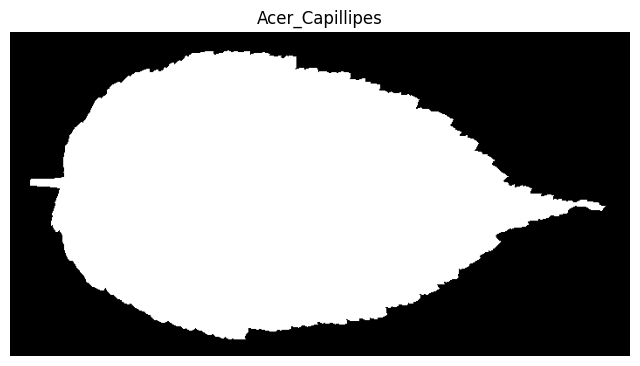

In [4]:
species = np.array(sorted(train.species.unique()))
species_examples = [np.random.choice(train[train.species == s].id.values) for s in species]

indexes = [image_paths.index(os.path.join(current_directory,"images\{}.jpg").format(i).format(i)) for i in species_examples]

# Display the first image
plt.figure(figsize=(8, 8))
image = imread(image_paths[indexes[0]], as_gray=True)
plt.imshow(image, cmap='gray')
plt.title("%s" % (species[0]))
plt.axis('off')
plt.show()

## Exercise 2
2.1) In general it is a good approach to visualize an image for each category to get a better feeling of the task. You should now write some code to show 1 image from each category. You might want to use plt.subplot().

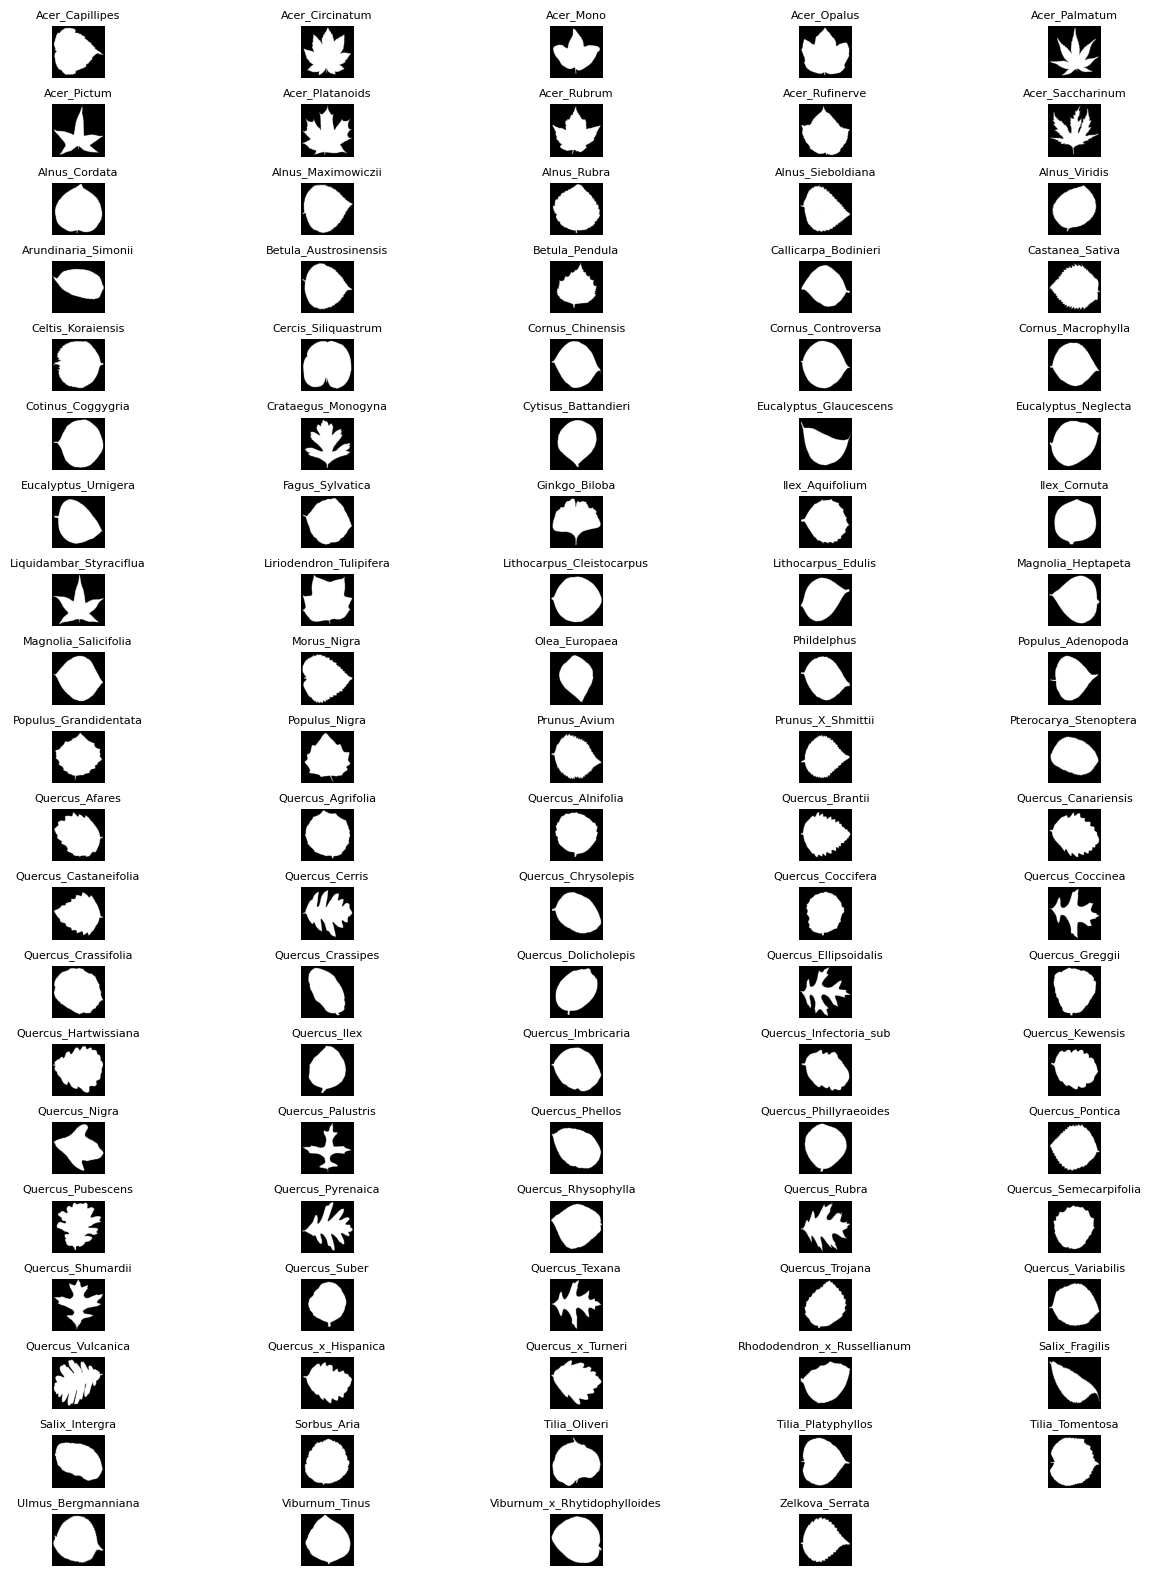

In [5]:
species = np.array(sorted(train.species.unique())) #99 Species

species_examples = [np.random.choice(train[train.species == s].id.values) for s in species]

image_paths_with_base = [os.path.join(image_base_path, '{}.jpg'.format(i)) for i in species_examples]

num_species = len(species)
cols = 5  
rows = int(np.ceil(num_species / cols))

plt.figure(figsize=(15, 20))

standard_shape = (256, 256)  # You can adjust this size as needed

for i, (s, img_path) in enumerate(zip(species, image_paths_with_base)):
    plt.subplot(rows, cols, i+1)
    image = imread(img_path, as_gray=True)
    image_resized = resize(image, standard_shape)
    plt.imshow(image_resized, cmap='gray')
    plt.title(s, fontsize=8)  # Adjust font size for better visibility
    plt.axis('off')

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()


As you can see, classifying leaves is actually a very tough problem.
What makes it even worse is that we cannot use all the image data we have available.
In order to decrease the amount of computation needed, we need to reduce the size of the images as much as possible.
On top of that, our neural network usually only accepts fixed-size input tensors.
This means we will have to change the shape of the images so that they all have the same sizes.


Resizing is problematic because it alters the shape of the leaves, and for some of them, this is their most distinctive feature. Take a look at `Salix_Intergra` in the bottom left corner.
Describing this leaf without taking its shape into account seems extremely difficult.

Therefore we will 
1. first pad all the images into squares, and
2. then resize them.

## Exercise 3

3.1) **Find an appropriate image size**. Test various resizings of the image until you have found the smallest resizing of the image where you "can still differentiate between the images".
How small is too small should ultimately be determined by an actual test, but what makes sense visually is probably a good place to start.
Change the `image_size = (?, ?)` parameter below, and note your choice.
 * **Answer:**


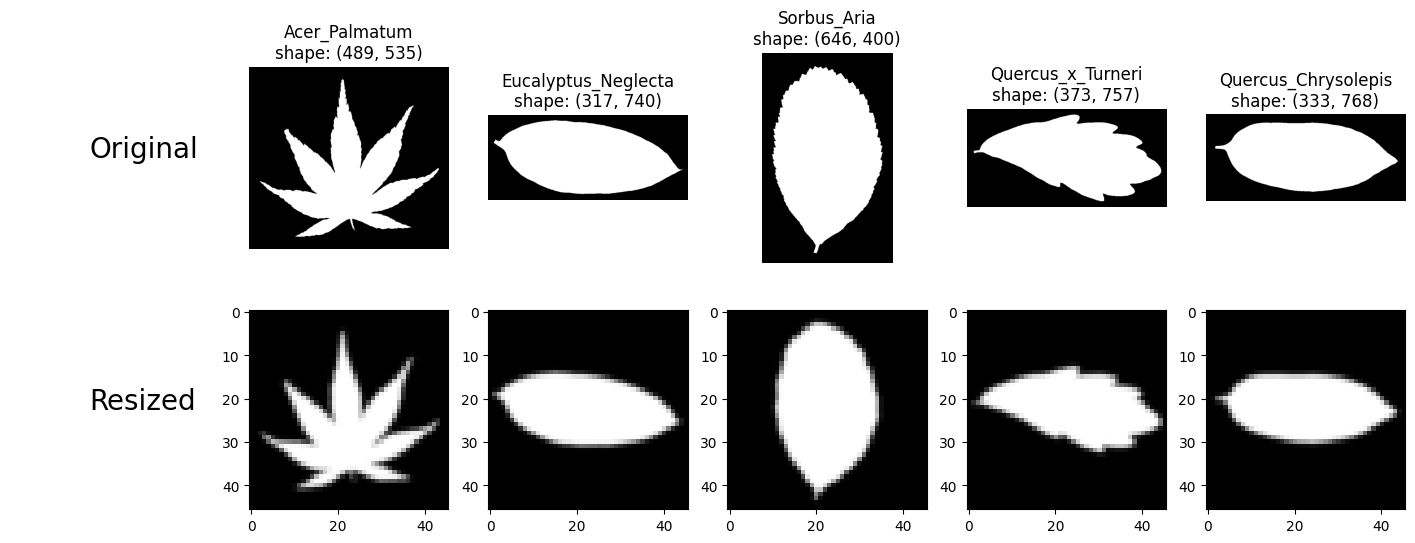

In [6]:
## Image pre-processing
IM_SZ = 46
image_size = (IM_SZ,IM_SZ)  # <-- YOUR CODE HERE
#####
#The original images have a max pixel size of 1000x1000. 
# Resizing to small is essentially a low pass filter. If you go smaller than 32x32, a lot of details are lost. By 64x64 there are more details but the finer details are still lost. 
# When up to 128x128 most of the high frequenncy components are visible to the human eye.
# I will attempt to use 128x128
#####

# Amount of images
amount = 5
image_sample = np.random.choice(train_images, amount)

# Define figure size
fig = plt.figure(figsize=(18, 6))

# Save original images in the figure
ax = plt.subplot(2, amount + 1, 1)
txt = ax.text(0.4, 0.5, 'Original', fontsize=20)
txt.set_clip_on(False)
plt.axis('off')
for i, path in enumerate(image_sample):
    plt.subplot(2, amount + 1, i + 2)
    image = imread(path, as_gray=True)    
    plt.imshow(image, cmap='gray')
    _id = int(path.split('/')[-1].split('.')[0])
    plt.title("{0}\nshape: {1}".format(train[train.id == _id].species.values[0], image.shape))
    plt.axis('off')
    
# Save resized images in the figure
ax = plt.subplot(2, amount + 1, len(image_sample) + 2)
txt = ax.text(0.4, 0.5, 'Resized', fontsize=20)
txt.set_clip_on(False)
plt.axis('off')
for i, path in enumerate(image_sample):
    i += len(image_sample) + 3
    plt.subplot(2, amount + 1, i)
    image = imread(path, as_gray=True)
    image = data_utils.pad2square(image)  # Make the image square
    image = resize(image, output_shape=image_size, mode='reflect', anti_aliasing=True)  # resizes the image
    plt.imshow(image, cmap='gray')

# Show plot
plt.show()

## Investigating the other features

Now that we have looked at the image data we have available, it is time to take a look at the other available features. Below we choose a random subset of the training data, and visualize the 3 types of available features:
* margin
* shape
* texture

Run it a few times to try and get an understanding of how the features differ from species to species.

(990, 64)
(990, 64)
(990, 64)


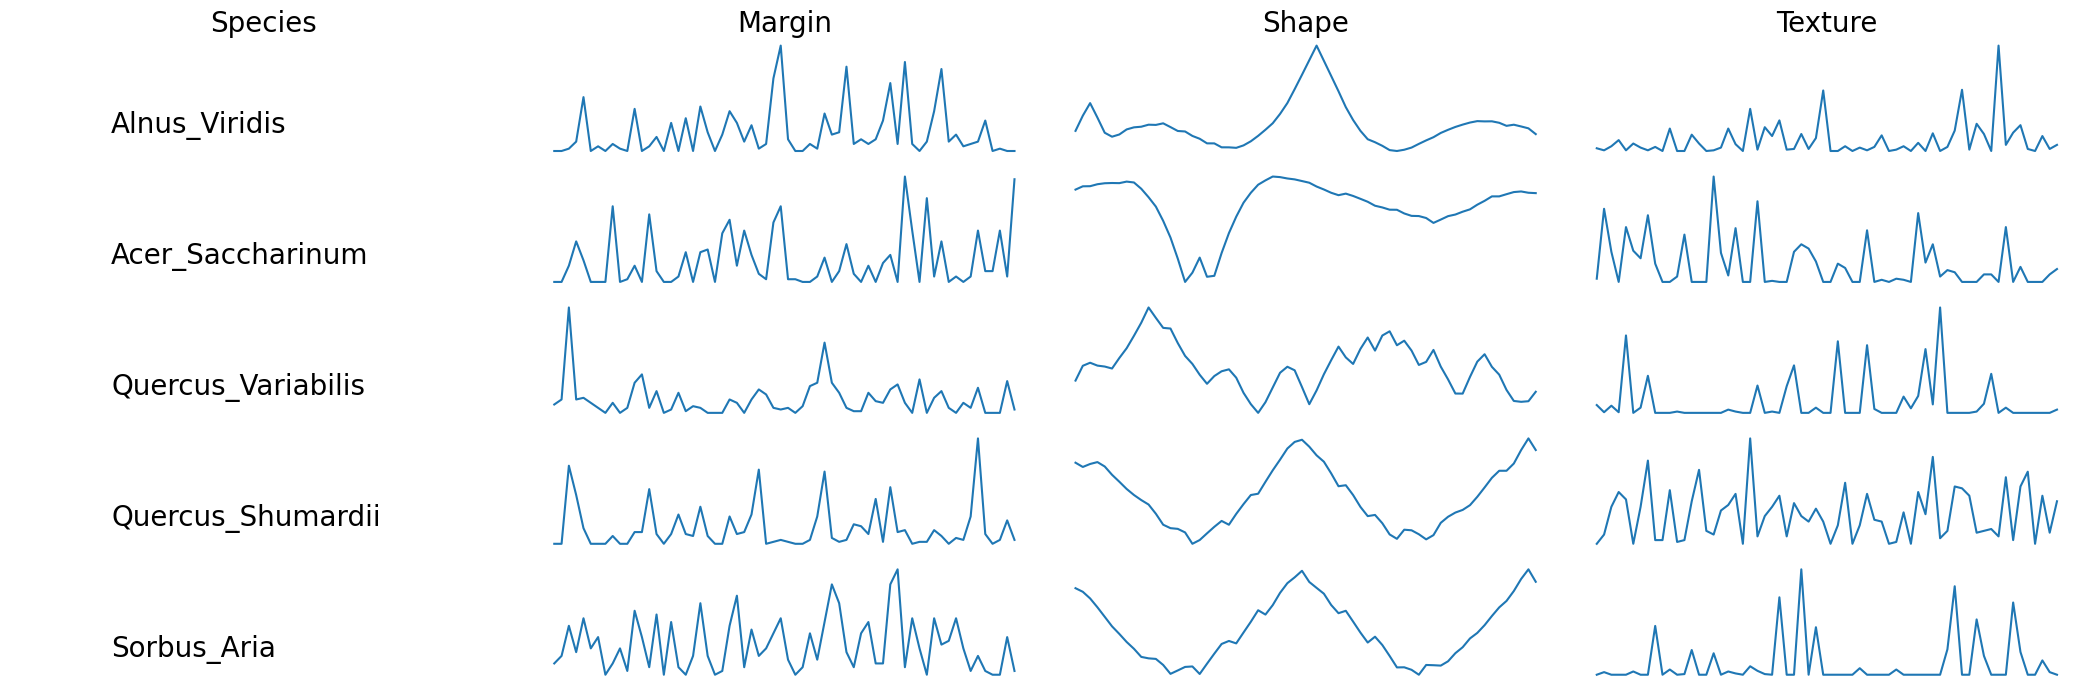

In [7]:
# Extract features
X = train.values
species = X[:, 1:2]
margin = X[:, 2:66]
shape = X[:, 66:130]
texture = X[:, 130:]

# Let us plot some of the features
plt.figure(figsize=(21,7)) # Set the plot size
amount = 5                 # Choose the amount of images we want to show at a time

for i, idx in enumerate(np.random.choice(range(len(train)), amount)):
    ax = plt.subplot(amount,4,1+i*4)
    txt = ax.text(0.2, 0.2, species[idx][0], fontsize=20)
    txt.set_clip_on(False)
    plt.axis('off')
    if i == 0:
        plt.title('Species', fontsize=20)
    plt.subplot(amount,4,2+i*4)
    plt.plot(margin[idx])
    if i == 0:
        plt.title('Margin', fontsize=20)
    plt.axis('off')
    plt.subplot(amount,4,3+i*4)
    plt.plot(shape[idx])
    if i == 0:
        plt.title('Shape', fontsize=20)
    plt.axis('off')
    plt.subplot(amount,4,4+i*4)
    plt.plot(texture[idx])
    if i == 0:
        plt.title('Texture', fontsize=20)
    plt.axis('off')

print(texture.shape)
print(margin.shape)
print(shape.shape)

plt.tight_layout()
plt.show()

## Exercise 4
So far we have learned about feed forward neural networks (FFNN), convolutional neural networks (CNN), recurrent neural networks (RNN), and transformers.

4.1) How could the `image`, `Margin`, `Shape` and `Texture` be used for classification, i.e. what kind of network type would you use for each of them, and why?
 * **Answer:**
 

# Managing the data

The details of the code in this section isn't that important.
It simply manages the data in a nice way - so it is a good place to come back and look for inspiration when you will work on your own projects.


## Defining the data loader

## Exercise 5 
5.1) As a part of the data loader, we should specify the shape of the images, number of classes, and the number of features for the three feature types: margin, shape and texture. Define the three variables in the code below.

In [8]:
# The image shape should be of the format (height, width, channels)
IMAGE_SHAPE = (32,32,1)   # <-- Your answer here
NUM_CLASSES = len(train.species.unique())  # <-- Your answer here

# For all three features types margin, shape, and texture, we have NUM_FEATURES for each type.
NUM_FEATURES = (64,64,64)  # <-- Your answer here

In [9]:
# Paths to data
TRAIN_PATH = train_path 
TEST_PATH = test_path
IMAGE_PATHS = glob.glob(image_path)

# train holds both X (input) and t (target/truth)
data = data_utils.load_data(train_path=TRAIN_PATH, 
                            test_path=TEST_PATH,
                            image_paths=IMAGE_PATHS,
                            image_shape=IMAGE_SHAPE[:2])
 #to visualize the size of the dimensions of the data


Loading training data
	0 of 990
	100 of 990
	200 of 990
	300 of 990
	400 of 990
	500 of 990
	600 of 990
	700 of 990
	800 of 990
	900 of 990
Loading test data
	0 of 594
	100 of 594
	200 of 594
	300 of 594
	400 of 594
	500 of 594


#### Do you want to load your data quickly next time?
In the above cell the data is loaded, reshaped and stored as an object. If you want load this object quickly next time you should go for pickle. Pickle does effectively write an object into a character stream, so it can be loaded fastly next time. Simply replace `drive_path` with you `local_path` if you're not using colab. 

In [10]:
import pickle

# # Dump the data into a pickle file
with open(current_directory + '/data.pickle', 'wb') as f:
     pickle.dump(data, f)

In [11]:
 # Load the data from a pickle file
with open(current_directory + '/data.pickle', 'rb') as f:
    data = pickle.load(f)

## Batch Generator

While training, we will not directly access the entire dataset, instead we have a `batch_generator` function to give us inputs aligned with their targets/ids in a size that our model can handle in memory (batch\_size).

Furthermore, the `batch_generator` also handles validation splitting.

## Exercise 6
6.1) Explain shortly why the size of batches is important. You should comment on how the size of batches affect the memory, training speed, and the estimates of the gradients.
Choose a reasonable batch size the `batch_size = ?` parameter below, and note your choice.

 * **Answer:**

In [12]:
batch_size = 32
dummy_batch_gen = data_utils.batch_generator(data, batch_size=batch_size, num_classes=NUM_CLASSES, num_iterations=5e3, seed=42)
train_batch = next(dummy_batch_gen.gen_train())
valid_batch, i = next(dummy_batch_gen.gen_valid())
test_batch, i = next(dummy_batch_gen.gen_test())

print("TRAIN")
print("\timages,", train_batch['images'].shape)
print("\tmargins,", train_batch['margins'].shape)
print("\tshapes,", train_batch['shapes'].shape)
print("\ttextures,", train_batch['textures'].shape)
print("\tts,", train_batch['ts'].shape)
print()
print("VALID")
print("\timages,", valid_batch['images'].shape)
print("\tmargins,", valid_batch['margins'].shape)
print("\tshapes,", valid_batch['shapes'].shape)
print("\ttextures,", valid_batch['textures'].shape)
print("\tts,", valid_batch['ts'].shape)
print()
print("TEST")
print("\timages,", test_batch['images'].shape)
print("\tmargins,", test_batch['margins'].shape)
print("\tshapes,", test_batch['shapes'].shape)
print("\ttextures,", test_batch['textures'].shape)
print("\tids,", len(test_batch['ids']))

TRAIN
	images, (32, 32, 32, 1)
	margins, (32, 64)
	shapes, (32, 64)
	textures, (32, 64)
	ts, (32, 99)

VALID
	images, (32, 32, 32, 1)
	margins, (32, 64)
	shapes, (32, 64)
	textures, (32, 64)
	ts, (32, 99)

TEST
	images, (32, 32, 32, 1)
	margins, (32, 64)
	shapes, (32, 64)
	textures, (32, 64)
	ids, 32


# Build the model

In [13]:
use_cuda = torch.cuda.is_available()
print("Running GPU.") if use_cuda else print("No GPU available.")


def get_variable(x):
    """ Converts tensors to cuda, if available. """
    if use_cuda:
        return x.cuda()
    return x


def get_numpy(x):
    """ Get numpy array for both cuda and not. """
    if use_cuda:
        return x.cpu().data.numpy()
    return x.data.numpy()

Running GPU.


## Exercise 7
7.1)  Now you must define the network architecture. It is always a good idea to start simple. We recommend you to start with a mix of a convolutional layer (maybe followed by max pooling layer), a recurrent layer, and a linear output layer such that we use all the features.  

When you build the model you should be aware of the dimensions of the input and output for your different layers. The function`permute` and `view` will be very useful to rearrange your dimensions.

In [14]:
height, width, channels = IMAGE_SHAPE
H_SZ = 64
batch_size = 32

conv_out_channels = 12 # <-- Filters in your convolutional layer
conv2_out_channels = 24
kernel_size = 3       # <-- Kernel size
conv_stride = 1       # <-- Stride
conv_pad    = 1       # <-- Padding

# Keep track of features to output layer
features_cat_size = conv2_out_channels*height//4*width//4+2*64+H_SZ# <-- Number of features concatenated before output layer
print(features_cat_size)
import torch.nn.functional as F
from torch.nn import Conv2d, Linear, MaxPool2d, BatchNorm2d, BatchNorm1d, Dropout

hidden_neurons = 768  # <-- Number of neurons in the hidden layer
dropout_probability = 0.55  # <-- Dropout rate

class Net(nn.Module):
    def __init__(self, rnn_hidden_size):
        super(Net, self).__init__()
        
        # Convolutional Layer
        self.conv_1 = Conv2d(in_channels=channels,
                             out_channels=conv_out_channels,
                             kernel_size=kernel_size,
                             stride=conv_stride,
                             padding=conv_pad)
        self.bn_conv1 = BatchNorm2d(conv_out_channels)  # Batch normalization for convolutional layer
        self.max_pool1 = MaxPool2d(kernel_size=2)

        self.conv_2 = Conv2d(in_channels=conv_out_channels,
                      out_channels=conv2_out_channels,
                      kernel_size=kernel_size,
                      stride=conv_stride,
                      padding=conv_pad)
        self.bn_conv2 = BatchNorm2d(conv2_out_channels)
        self.max_pool2 = MaxPool2d(kernel_size=2)



        
        
        # RNN Layer
        self.rnn_1 = nn.RNN(input_size=(2*64), hidden_size=rnn_hidden_size, batch_first=True)

        # Hidden FFNN Layer
        self.l_hidden = nn.Linear(in_features=features_cat_size, out_features=hidden_neurons)
        self.bn_hidden = BatchNorm1d(hidden_neurons)  # Batch normalization for hidden FFNN layer
        
        # Dropout Layer
        self.dropout = Dropout(p=dropout_probability)
        
        # Output Layer
        self.l_out = Linear(in_features=hidden_neurons, out_features=NUM_CLASSES, bias=False)
        
        # Activation
        self.activation = nn.ReLU()

    def forward(self, x_img, x_margin, x_shape, x_texture, DEBUG=False):
        features = []
        input_im_dim = x_img.dim()
        if(input_im_dim == 4): #batch_sz, W, H, C
          batch_sz = x_img.shape[0]
        else:
          batch_sz = 1

        # Convolutional Layer
        x_img = get_numpy(x_img)
        x_img = resize(x_img, output_shape=(batch_sz, height, width), mode="reflect", anti_aliasing=True)
        x_img = get_variable(torch.from_numpy(x_img))
        x_img = torch.permute(x_img, dims=(0, -1, 1, 2))
        features_img = self.conv_1(x_img)
        features_img = self.bn_conv1(features_img)  # Apply batch normalization
        features_img = self.activation(features_img)
        features_img = self.max_pool2(features_img)

        features_img = self.conv_2(features_img)
        features_img = self.bn_conv2(features_img)  # Apply batch normalization for second conv layer
        features_img = self.activation(features_img)
        features_img = self.max_pool2(features_img)
        features.append(torch.reshape(features_img,(batch_sz,-1)))
        
        # Concatenated Leaf Features
        x = torch.cat((x_margin, x_texture), dim=1)
        features_vector = x.view(batch_sz, 128)
        features.append(features_vector)
        
        # RNN Layer
        features_rnn = self.rnn_1(features_vector)[0]
        features.append(features_rnn)

        # Combine features and pass through FFNN layers
        features_final = torch.cat(features, dim=-1)
        features_final = self.l_hidden(features_final)
        features_final = self.bn_hidden(features_final)  # Apply batch normalization
        features_final = self.activation(features_final)
        features_final = self.dropout(features_final)  # Apply dropout
        out = {'out': self.l_out(features_final)}

        return out

net = Net(rnn_hidden_size=H_SZ)
if use_cuda:
    net.cuda()
print(net)


net = Net(rnn_hidden_size=H_SZ)
if use_cuda:
    net.cuda()
print(net)

1728
Net(
  (conv_1): Conv2d(1, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_conv1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_2): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_conv2): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (rnn_1): RNN(128, 64, batch_first=True)
  (l_hidden): Linear(in_features=1728, out_features=768, bias=True)
  (bn_hidden): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.55, inplace=False)
  (l_out): Linear(in_features=768, out_features=99, bias=False)
  (activation): ReLU()
)
Net(
  (conv_1): Conv2d(1, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_conv1): BatchNorm2d(12, eps=1e-05, momen

# Build the cost function

## Exercise 8
8.1) Since this is a classification task we will use the cross-entropy loss. Define the cross-entropy loss as the loss function in the code below.

In [15]:
LEARNING_RATE = 1e-3
criterion = nn.CrossEntropyLoss() # <-- Your code here.

# weight_decay is equal to L2 regularization
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

def accuracy(ys, ts):
    predictions = torch.max(ys, 1)[1]
    correct_prediction = torch.eq(predictions, ts)
    return torch.mean(correct_prediction.float())

## Test network

#### Debugging 
The following cell might cause you some errors - try these suggestions before you try anyting else.

* **Your kernel keeps dying** on the line below it is most likely because you run out of memory.
The two most likely solutions are 
 1. reduce the image size further
 1. change your network architecture such that it uses less resources

* **`RuntimeError: size mismatch, m1: [??? x ???], m2: [??? x ???]`** 
 1. `features_cat_size` must match the actual output of the network i.e. the second dimension in `m1`.

* **Training is very slow**. This is most likely caused by the images. 
 1. Try and reduce the size of the images further, or reduce the dimensions of the network using either pooling or strides.


In [16]:
_img_shape = tuple([batch_size] + list(IMAGE_SHAPE))
_feature_shape = (batch_size,) + (64,)


def randnorm(size):
    return np.random.normal(0, 1, size=size).astype('float32')

# dummy data
_x_image = get_variable(Variable(torch.from_numpy(randnorm(_img_shape))))
_x_margin = get_variable(Variable(torch.from_numpy(randnorm(_feature_shape))))
_x_shape = get_variable(Variable(torch.from_numpy(randnorm(_feature_shape))))
_x_texture = get_variable(Variable(torch.from_numpy(randnorm(_feature_shape))))

print(_x_shape.shape)
print(_x_texture.shape)
x = torch.cat((_x_margin, _x_texture), dim=1)  # if you want to use features as feature vectors
print(x.shape)




torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 128])


In [17]:
output = net(x_img=_x_image, x_margin=_x_margin, x_shape=_x_shape, x_texture=_x_texture)
print(output['out'])
print(output['out'].shape)
print(torch.sum(output['out'],dim=1)) #check that the feature dimension sums to 1 after using softmax


tensor([[ 0.2032, -0.5684,  0.8169,  ..., -0.9802,  0.5686, -0.2733],
        [ 0.0196, -0.3642, -0.4415,  ...,  0.7338, -0.4387, -1.1761],
        [ 0.8137, -0.7693,  0.8151,  ..., -0.3184,  0.0232,  0.3602],
        ...,
        [-0.3387, -0.0932, -0.7604,  ..., -1.0045,  0.5997, -0.2347],
        [ 0.0938,  0.1317,  0.8578,  ..., -0.1332, -0.3850, -0.4869],
        [-0.6951, -0.3415,  0.3327,  ..., -0.3795, -0.0428,  0.4177]],
       device='cuda:0', grad_fn=<MmBackward0>)
torch.Size([32, 99])
tensor([-7.8802e+00,  3.3753e+00,  4.9454e+00,  6.2934e+00,  9.8204e+00,
         8.3261e-01, -4.3457e+00, -6.8788e+00,  2.5107e+00, -6.2702e+00,
         5.0532e+00, -5.5376e+00,  4.8487e+00, -1.3113e+00,  3.6695e-03,
        -6.2888e+00, -6.7064e+00,  8.2959e+00, -8.9006e-01,  3.3215e+00,
         7.9347e+00, -6.3322e+00, -5.5480e+00,  1.9121e-01, -4.2600e+00,
         4.1105e+00, -6.5934e+00, -1.7531e+00, -1.6030e+00,  2.4957e+00,
        -9.0885e-01, -2.8992e+00], device='cuda:0', grad_fn=

# Train

In [18]:
# Function to get label
def get_labels(batch):
    return get_variable(Variable(torch.from_numpy(batch['ts']).long()))

# Function to get input
def get_input(batch):
    return {
        'x_img': get_variable(Variable(torch.from_numpy(batch['images']))),
        'x_margin': get_variable(Variable(torch.from_numpy(batch['margins']))),
        'x_shape': get_variable(Variable(torch.from_numpy(batch['shapes']))),
        'x_texture': get_variable(Variable(torch.from_numpy(batch['textures'])))
    }

In [19]:
VALIDATION_SIZE = 0.1 # 0.1 is ~ 100 samples for validation
max_iter = 1500
log_every = 1
eval_every = 1

# Initialize lists for training and validation
train_iter = []
train_loss, train_accs = [], []
valid_iter = []
valid_loss, valid_accs = [], []
latest_val_acc = 0.0


# Generate batches
batch_gen = data_utils.batch_generator(data,
                                       batch_size=batch_size,
                                       num_classes=NUM_CLASSES,
                                       num_iterations=max_iter,
                                       seed=42,
                                       val_size=VALIDATION_SIZE)

# Train network
net.train()
progress_bar = tqdm(range(max_iter), desc="Training")

for i, batch_train in enumerate(batch_gen.gen_train()):
    if i % eval_every == 0:
        
        # Do the validaiton
        net.eval()
        val_losses, val_accs, val_lengths = 0, 0, 0
        for batch_valid, num in batch_gen.gen_valid():
            output = net(**get_input(batch_valid))
            labels_argmax = torch.max(get_labels(batch_valid), 1)[1]
            val_losses += criterion(output['out'], labels_argmax) * num
            val_accs += accuracy(output['out'], labels_argmax) * num
            val_lengths += num

        # Divide by the total accumulated batch sizes
        val_losses /= val_lengths
        val_accs /= val_lengths
        valid_loss.append(get_numpy(val_losses))
        valid_accs.append(get_numpy(val_accs))
        valid_iter.append(i)
        net.train()
    
    # Train network
    output = net(**get_input(batch_train))
    labels_argmax = torch.max(get_labels(batch_train), 1)[1]
    batch_loss = criterion(output['out'], labels_argmax)
    
    train_iter.append(i)
    train_loss.append(float(get_numpy(batch_loss)))
    train_accs.append(float(get_numpy(accuracy(output['out'], labels_argmax))))
    
    optimizer.zero_grad()
    batch_loss.backward()
    optimizer.step()

    # Update progress bar
    progress_bar.set_postfix({'training_loss': '{:.3f}'.format(train_loss[-1]), 
                              'training_acc': '{:.3f}'.format(train_accs[-1]), 
                              'validation_acc': '{:.3f}'.format(valid_accs[-1])})
    progress_bar.update()

    if max_iter < i:
        break

progress_bar.close()

Training: 1502it [00:56, 26.43it/s, training_loss=0.001, training_acc=1.000, validation_acc=0.889]                          


0.8888889


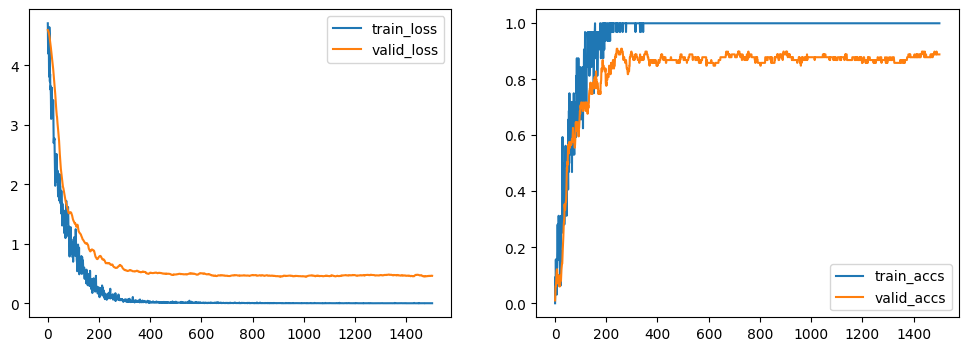

In [20]:
print(valid_accs[-1])

fig = plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(train_iter, train_loss, label='train_loss')
plt.plot(valid_iter, valid_loss, label='valid_loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_iter, train_accs, label='train_accs')
plt.plot(valid_iter, valid_accs, label='valid_accs')
plt.legend()
plt.show()
clear_output(wait=True)

In [21]:
valid_loss_floats = [float(acc) for acc in valid_loss]
train_loss_floats = [float(acc) for acc in train_loss]

valid_accs_floats = [float(acc) for acc in valid_accs]
train_accs_floats = [float(acc) for acc in train_accs]



# Calculate the step size for 10% of the list length
step_size_valid_loss = len(valid_loss_floats) // 10
step_size_train_loss = len(train_loss_floats) // 10

step_size_valid_accs = len(valid_accs_floats) // 10
step_size_train_accs = len(train_accs_floats) // 10

print("Loss: Train|Vali")
print([f"{acc:.3f}" for idx, acc in enumerate(train_loss_floats) if idx % step_size_train_loss == 0])
print([f"{acc:.3f}" for idx, acc in enumerate(valid_loss_floats) if idx % step_size_valid_loss == 0])


print("Accuracy: Train|Vali")
print([f"{acc:.3f}" for idx, acc in enumerate(train_accs_floats) if idx % step_size_train_accs == 0])
print([f"{acc:.3f}" for idx, acc in enumerate(valid_accs_floats) if idx % step_size_valid_accs == 0])


Loss: Train|Vali
['4.708', '0.336', '0.052', '0.011', '0.007', '0.004', '0.002', '0.002', '0.001', '0.001', '0.001']
['4.594', '1.006', '0.558', '0.500', '0.505', '0.463', '0.455', '0.465', '0.472', '0.470', '0.466']
Accuracy: Train|Vali
['0.000', '0.969', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000']
['0.010', '0.778', '0.889', '0.869', '0.859', '0.889', '0.889', '0.889', '0.869', '0.869', '0.889']


## Exercise 9

**Tip** This is a very small dataset (number of observations) compared to the number of features.
This means that overfitting may be an issue, and sometimes fancy tricks won't do any good. 
Keep that in mind, and always start simple.

**3.1) Improve the network**, and get as high a validation score as you can. 
When trying to improve the network nothing is sacred. You can try various learning rates, batch sizes, validation sizes, etc. 
And most importantly, the validation set is very small (only 1 sample per class), etc.

To get you off to a good start we have created a list of **things you might want to try**:
* Add more layers (mostly fully connected and convolutional)
* Increase or decrease the batch size 
* Use dropout (a lot - e.g. between the convolutional layers)
* Use batch normalization (a lot)
* Try with L2 regularization (weight decay)
* Use only the image for training (with CNN) - comment on the increased time between iterations.
* Change the image size to be bigger or smaller
* Try other combinations of FFN, CNN, RNN parts in various ways (bigger is not always better)

If your network is not performing as well as you would like it to, [here](http://theorangeduck.com/page/neural-network-not-working) is a great explanation of what might have gone wrong.


**3.2) Improve Kaggle score**. Once happy try to get the best score on Kaggle for this dataset as you can (**upload** instructions below)
You can upload your solution multiple times as you progress.
A very good implementation would get a score between $0.04$ to $0.06$ (the smaller the better), try and see if you can get there, and explain what might have gone wrong if you can't. 


**3.3) Reflect on the process**, and how you got to your final design and discuss your final results. 
What worked, and what didn't?
Include at least the following: 
* Description of the final architecture
* Description of the training parameters
* Description of the final results (Kaggle and validation)

**Answer:**

> A lot of different things have changed most specifically the architecture. Going between a FFNN + CNN and a FFNN + CNN + RNN. Within these combinations; The optimal was a combination and using texture and margin for the RNN, 2 FFNN and 2 Convolutions layers with kernel size 3 and a low amount of neurons. 

> Hyperparameters: The adam optimizer was used with learning rate and weight decay. The optimal values found were LR = 1e-3 and WD = 1e-5. Both LR and WD, did not siginifincantly improve performance. It was the the overall architecture and then fine tuning the parameters that made a difference. Also the batch size was used as a regularizer for overfitting. In the end 32 was chosen.

> CNN: Kernel size of 3 and 5 were experimented with where the image sizing was between 32x32 and 128x128. In the net 32x32 was used. Stride and padding were set to 1. There has been tried with 1, 2 and 3 layers of convolution. Dropout was essential for combatting overfitting, both in the CNN and the FFNN.

> RNN: The texture and margin yielded good results when using the RNN. I tried with using shape however, it did not improve the model performance. It could be interesting to try GRU or LTSM with positional encoding to see how that affect performance. I decided not to do this because of time and dataset constraint. 

> FFNN: A varying amount of neurons and layers has been tried. 1 hidden layer before classification seems to work quite well. They hidden layer should have a large amount of neurons.

> It seems that the convolution layers contained a lot less information about the classification that expected. The RNN with the FFNN seemed to help the model performance a lot. In the end a kaggle score of: $4.59511$ and validation accuracy of $88.9%$. This is lower than what I hoped for. 

> In terms of improvement, I think the most important one is data augmentation to "create" more data. Due to the constraints of the dataset and that some leaves are rotated 90 degreees, I think it would improve the classifier significantly. I also think playing around more with the RNN would be better. Initially I assumed that the CNN would do most of the work but it seems that the initial layer is good at finding edges but the higher frequency details are found by the FFNN and the RNN.

# Submission to Kaggle

First we have to make test set predictions, then we have to place the output in the submission file and then upload to Kaggle to get our score! You can upload up to 5 submissions per day.

In [26]:
# GET PREDICTIONS
# containers to collect ids and predictions
ids_test, preds_test = [], []
net.eval()
# run like with validation
for batch_test, num in batch_gen.gen_test():
    output = net(**get_input(batch_test))
    y_out = abs(output['out'].data.cpu())  # Move tensor to CPU

    ids_test += batch_test['ids']
    if num != len(y_out):
        # in case of the last batch, num will be less than batch_size
        y_out = y_out[:num]
    preds_test.append(y_out.numpy())  # Convert tensor to numpy array

preds_test = np.concatenate(preds_test, axis=0)
assert len(ids_test) == len(preds_test)


## Make submission file

In [27]:
preds_df = pd.DataFrame(preds_test, columns=data.le.classes_)
ids_test_df = pd.DataFrame(ids_test, columns=["id"])
submission = pd.concat([ids_test_df, preds_df], axis=1)
submission.to_csv(current_directory + 'submission.csv', index=False)

# below prints the submission, can be removed and replaced with code block below
submission.head(5)

,id,Acer_Capillipes,Acer_Circinatum,Acer_Mono,Acer_Opalus,Acer_Palmatum,Acer_Pictum,Acer_Platanoids,Acer_Rubrum,Acer_Rufinerve,...,Salix_Fragilis,Salix_Intergra,Sorbus_Aria,Tilia_Oliveri,Tilia_Platyphyllos,Tilia_Tomentosa,Ulmus_Bergmanniana,Viburnum_Tinus,Viburnum_x_Rhytidophylloides,Zelkova_Serrata
0,4,8.998797,9.185966,11.908895,6.680038,8.483970,11.342845,11.314011,7.704656,6.955882,...,11.709651,9.666758,8.503212,10.866103,9.197728,10.943285,12.344660,5.211185,11.902587,12.276711
1,7,9.376931,9.274172,7.115501,8.750588,8.298392,7.453078,8.788164,8.910150,8.478696,...,9.233711,7.474416,10.444201,10.439791,8.944288,9.436081,8.670817,9.692965,9.075761,6.421862
2,9,6.848874,1.297845,9.262810,4.770494,6.833910,8.418868,5.122260,4.866502,6.644295,...,11.603373,8.741496,9.279418,8.486588,7.985301,6.111046,8.594882,7.332331,8.237451,7.630183
3,12,13.875090,11.142374,12.172649,10.069255,13.350175,11.741066,12.927095,8.855771,8.713250,...,9.954207,7.636215,8.296491,10.294146,10.832190,12.629869,7.704921,13.187301,6.093990,11.759866
4,13,10.026528,6.816389,11.964949,6.137455,8.451288,8.876242,6.986720,7.912984,5.455654,...,10.107684,11.832767,4.489834,4.539314,5.545205,6.290319,8.093638,10.827796,8.564960,10.782056


## Upload submission

1. Go to [`https://www.kaggle.com/c/leaf-classification/submit`](https://www.kaggle.com/c/leaf-classification/submit)
3. Click or drop your submission here (writing a description is good practice)
4. Submit and look at where you are on the leaderboard.

Success! 